In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.covariance import LedoitWolf
from sklearn.cluster import DBSCAN
from hdbscan import HDBSCAN
from clusteval import clusteval

from DP_functions import *

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

np.set_printoptions(suppress=True)
pd.options.display.float_format = '{:.7f}'.format

### Walk-Forward Backtesting

In [2]:
df = pd.read_csv('NCO_data.csv', index_col='Unnamed: 0')
returns = pd.DataFrame(index=df.index)

for column in df.columns:
    returns[column] = df[column]/df[column].shift(1) - 1
    
returns = returns.dropna(axis=0)

In [3]:
start = 0
end = 410
n_iter = len(returns) - end
intervals = []

for i in range(n_iter + 1):
    intervals.append(returns.index[start:end])
    start += 1
    end += 1

In [4]:
minvar_portfolio_returns, eqwidth_portfolio_returns, hnco_portfolio_returns = [], [], []
for int_ in tqdm(intervals):
    train_i = returns.loc[int_[:-1]]
    test_i = returns.loc[int_[-1]]
    cov0 = train_i.cov()
    cov_dnsd = deNoiseCov(cov0, q=cov0.shape[0]/cov0.shape[1], bWidth=.05)
    lw = LedoitWolf()
    cov = lw.fit(cov_dnsd).covariance_
    corr = cov2corr(cov)
    corr_df = pd.DataFrame(corr, index=cov0.index, columns=cov0.columns)
    cov_df = pd.DataFrame(cov, index=cov0.index, columns=cov0.columns)
    
    eqwidth_w = np.ones(shape=len(cov))/len(cov)
    minvar_w = minVarPort(cov).flatten()
    
    eqwidth_return = eqwidth_w.dot(np.array(test_i))
    eqwidth_portfolio_returns.append(eqwidth_return)
    
    minvar_return = minvar_w.dot(np.array(test_i))
    minvar_portfolio_returns.append(minvar_return)
    
    length = cov0.shape[0]
    prox = np.sqrt(np.ones((length, length))/2 - np.array(corr)/2)
    prox_df = pd.DataFrame(prox, columns=cov0.columns, index=cov0.index)
    
    ce = clusteval(cluster='hdbscan')
    results = ce.fit(prox_df)
    labels = results['labx']
    labels[labels==-1] = len(set(labels)) - 1
    
    clstrs = {}
    for i in list(set(labels)):
        clstrs[i] = []

    j = 0    
    for i in labels:
        clstrs[i] += [corr_df.columns[j]]
        j += 1
    
    corr_clstrd = clstrdMatrix(corr_df, clstrs)[0]
    ordered_assets = clstrdMatrix(cov_df, clstrs)[1]
    
    wIntra = pd.DataFrame(0, index=cov_df.index, columns=clstrs.keys())
    for i in clstrs:
        cov_clstr_i = cov_df.loc[clstrs[i], clstrs[i]]
        wIntra.loc[clstrs[i], i] = minVarPort(cov_clstr_i).flatten()
        
    reduced_cov = wIntra.T.dot(cov_df).dot(wIntra)
    needed_clstrs = clstrs
    weights = []
    for i in wIntra.columns:
        weights.append(np.array(wIntra.loc[needed_clstrs[i], i]))
    mean_clstr_returns = clstrs_returns(train_i, needed_clstrs, weights)
    wInter = optPort(reduced_cov, mu=mean_clstr_returns).flatten() 
        
    wFinal = []
    j = 0
    for weight in wInter:
        wFinal += list(weight*wIntra.loc[
            needed_clstrs[j], j])
        j += 1
    
    ordered_test_i = test_i.loc[ordered_assets]
    hnco_portfolio_returns.append(np.array(wFinal).dot(np.array(ordered_test_i)))

  0%|                                                                                           | 0/82 [00:00<?, ?it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 40
[clusteval] >INFO> Silhouette Coefficient: 0.232
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [41].
[clusteval] >INFO> Fin.
  1%|█                                                                                  | 1/82 [00:01<01:39,  1.23s/it][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 40
[clusteval] >INFO> Silhouette Coefficient: 0.225
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [41].
[clusteval] >INFO> Fin.
  2%|██                                           

 21%|█████████████████                                                                 | 17/82 [00:16<01:07,  1.03s/it][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 44
[clusteval] >INFO> Silhouette Coefficient: 0.182
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [45].
[clusteval] >INFO> Fin.
 22%|██████████████████                                                                | 18/82 [00:18<01:19,  1.23s/it][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 42
[clusteval] >INFO> Silhouette Coefficient: 0.171
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [43].
[clusteval] >INFO> Fin.
 23%|███████████████████                          

 41%|██████████████████████████████████                                                | 34/82 [00:34<00:38,  1.23it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 42
[clusteval] >INFO> Silhouette Coefficient: 0.208
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [43].
[clusteval] >INFO> Fin.
 43%|███████████████████████████████████                                               | 35/82 [00:35<00:37,  1.26it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 40
[clusteval] >INFO> Silhouette Coefficient: 0.194
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [41].
[clusteval] >INFO> Fin.
 44%|████████████████████████████████████         

 62%|███████████████████████████████████████████████████                               | 51/82 [00:48<00:25,  1.22it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 47
[clusteval] >INFO> Silhouette Coefficient: 0.163
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [48].
[clusteval] >INFO> Fin.
 63%|████████████████████████████████████████████████████                              | 52/82 [00:49<00:24,  1.23it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 41
[clusteval] >INFO> Silhouette Coefficient: 0.194
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [42].
[clusteval] >INFO> Fin.
 65%|█████████████████████████████████████████████

 83%|████████████████████████████████████████████████████████████████████              | 68/82 [01:02<00:11,  1.21it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 41
[clusteval] >INFO> Silhouette Coefficient: 0.217
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [42].
[clusteval] >INFO> Fin.
 84%|█████████████████████████████████████████████████████████████████████             | 69/82 [01:03<00:10,  1.23it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 48
[clusteval] >INFO> Silhouette Coefficient: 0.176
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [49].
[clusteval] >INFO> Fin.
 85%|█████████████████████████████████████████████

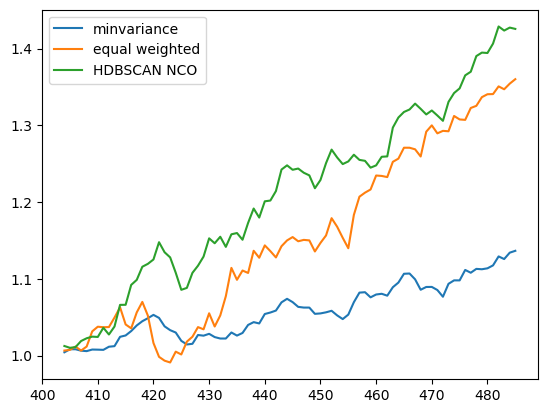

In [5]:
minvar_cumulative_returns = np.cumsum(minvar_portfolio_returns)
eqwidth_cumulative_returns = np.cumsum(eqwidth_portfolio_returns) 
hnco_cumulative_returns = np.cumsum(hnco_portfolio_returns)

plt.plot(range(404, 404 + len(minvar_cumulative_returns)), minvar_cumulative_returns+1, label='minvariance')
plt.plot(range(404, 404 + len(eqwidth_cumulative_returns)), eqwidth_cumulative_returns+1, label='equal weighted')
plt.plot(range(404, 404 + len(hnco_cumulative_returns)), hnco_cumulative_returns + 1, label='HDBSCAN NCO')
plt.legend()

Скачаем данные по недельным риск-фри рейтам.

In [6]:
RFs = pd.read_csv('F-F_Research_Data_Factors_weekly.csv', index_col='Unnamed: 0').RF
RFs = (1+RFs)**(1/252)-1
new_ind = []
for i in RFs.index:
    new_ind.append(i[:4] + '-' + i[4:6] + '-' + i[6:])
    
RFs.index = new_ind

needed_inds = []
for i in RFs.index:
    if i[:4] in ['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']:
        needed_inds.append(i)
        
wf_inds = needed_inds[410:492]
wf_rps = np.array(RFs.loc[wf_inds])

In [7]:
minvar_rp = minvar_portfolio_returns - wf_rps
eqwidth_rp = eqwidth_portfolio_returns - wf_rps
hnco_rp = hnco_portfolio_returns - wf_rps

mean_e, mean_m, mean_h = eqwidth_rp.mean(), minvar_rp.mean(), hnco_rp.mean()

In [8]:
summary = pd.DataFrame(index=['Net Return on Portfolio', 'Volatility (St.Dev.)', 'Sharpe Ratio'], \
                       columns=['Equal Weighted', 'MinVariance', 'HDBSCAN NCO'])

summary.iloc[0] = np.array([eqwidth_cumulative_returns, minvar_cumulative_returns, hnco_cumulative_returns]).T[-1]
summary.iloc[1] = [np.std(eqwidth_portfolio_returns), np.std(minvar_portfolio_returns), np.std(hnco_portfolio_returns)]
summary.iloc[2] = np.array([mean_e, mean_m, mean_h])/summary.iloc[1]

summary

,Equal Weighted,MinVariance,HDBSCAN NCO
Net Return on Portfolio,0.3601995,0.1365364,0.4257348
Volatility (St.Dev.),0.0136445,0.0062750,0.0120834
Sharpe Ratio,0.3193412,0.2597075,0.4267393


### Cross-validation Backtesting

In [9]:
cv_eqw_returns, cv_minvar_returns, cv_hnco_returns = [], [], []
for i in tqdm(range(returns.shape[0])):
    new_ret = returns.copy()
    test_i = new_ret.iloc[i]
    new_ret.drop(returns.index[i])
    sample = np.sort(random.sample(range(returns.shape[0]-1), 403))
    train_i = new_ret.iloc[sample]
    cov0 = train_i.cov()
    
    cov_dnsd = deNoiseCov(cov0, q=cov0.shape[0]/cov0.shape[1], bWidth=.05)
    lw = LedoitWolf()
    cov_df = pd.DataFrame(lw.fit(cov_dnsd).covariance_, columns=cov0.columns, index=cov0.index)
    corr = cov2corr(cov_df)
    corr_df = pd.DataFrame(np.array(corr), columns=cov_df.columns, index=cov_df.index)
    
    eqwidth_w = np.ones(shape=len(cov))/len(cov)
    minvar_w = minVarPort(cov).flatten()
    
    eqwidth_return = eqwidth_w.dot(np.array(test_i))
    cv_eqw_returns.append(eqwidth_return)
    
    minvar_return = minvar_w.dot(np.array(test_i))
    cv_minvar_returns.append(minvar_return)
    
    length = corr.shape[0]
    prox = np.sqrt(np.ones((length, length))/2 - np.array(corr)/2)
    prox_df = pd.DataFrame(prox, columns=cov0.columns, index=cov0.index)
    
    ce = clusteval(cluster='hdbscan')
    results = ce.fit(prox_df)
    labels = results['labx']
    labels[labels==-1] = len(set(labels)) - 1
    
    clstrs = {}
    for i in list(set(labels)):
        clstrs[i] = []

    j = 0    
    for i in labels:
        clstrs[i] += [corr_df.columns[j]]
        j += 1
    
    corr_clstrd = clstrdMatrix(corr_df, clstrs)[0]
    ordered_assets = clstrdMatrix(cov_df, clstrs)[1]
    
    wIntra = pd.DataFrame(0, index=ordered_assets, columns=clstrs.keys())
    cov_df = cov_df.loc[ordered_assets, ordered_assets]
    mean_clstr_returns = []
    for i in clstrs:
        cov_clstr_i = cov_df.loc[clstrs[i], clstrs[i]]
        ordered_train_i = train_i.loc[:, ordered_assets]
        mean_returns = ordered_train_i[clstrs[i]].mean(axis=0)
        wIntra.loc[clstrs[i], i] = optPort(cov_clstr_i, mu=mean_returns).flatten()
        mean_clstr_returns.append(np.array(wIntra.loc[clstrs[i], i]).dot(mean_returns))
        
    reduced_cov = wIntra.T.dot(cov_df).dot(wIntra)
    needed_clstrs = clstrs
    wInter = optPort(reduced_cov, mu=mean_clstr_returns).flatten() 
        
    wFinal = wIntra.dot(wInter)
    
    ordered_test_i = test_i.loc[ordered_assets]
    cv_hnco_returns.append(np.array(wFinal).dot(np.array(ordered_test_i)))

  0%|                                                                                          | 0/491 [00:00<?, ?it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 45
[clusteval] >INFO> Silhouette Coefficient: 0.141
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [46].
[clusteval] >INFO> Fin.
  0%|▏                                                                                 | 1/491 [00:00<07:14,  1.13it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 38
[clusteval] >INFO> Silhouette Coefficient: 0.195
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [39].
[clusteval] >INFO> Fin.
  0%|▎                                            

  3%|██▊                                                                              | 17/491 [00:14<07:03,  1.12it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 48
[clusteval] >INFO> Silhouette Coefficient: 0.169
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [49].
[clusteval] >INFO> Fin.
  4%|██▉                                                                              | 18/491 [00:15<06:59,  1.13it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 39
[clusteval] >INFO> Silhouette Coefficient: 0.229
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [40].
[clusteval] >INFO> Fin.
  4%|███▏                                         

  7%|█████▌                                                                           | 34/491 [00:29<06:59,  1.09it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 39
[clusteval] >INFO> Silhouette Coefficient: 0.216
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [40].
[clusteval] >INFO> Fin.
  7%|█████▊                                                                           | 35/491 [00:30<06:53,  1.10it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 45
[clusteval] >INFO> Silhouette Coefficient: 0.127
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [46].
[clusteval] >INFO> Fin.
  7%|█████▉                                       

 10%|████████▍                                                                        | 51/491 [00:44<06:20,  1.16it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 51
[clusteval] >INFO> Silhouette Coefficient: 0.132
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [52].
[clusteval] >INFO> Fin.
 11%|████████▌                                                                        | 52/491 [00:45<06:24,  1.14it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 44
[clusteval] >INFO> Silhouette Coefficient: 0.151
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [45].
[clusteval] >INFO> Fin.
 11%|████████▋                                    

 14%|███████████▏                                                                     | 68/491 [00:59<06:03,  1.16it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 44
[clusteval] >INFO> Silhouette Coefficient: 0.188
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [45].
[clusteval] >INFO> Fin.
 14%|███████████▍                                                                     | 69/491 [01:00<06:36,  1.06it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 47
[clusteval] >INFO> Silhouette Coefficient: 0.159
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [48].
[clusteval] >INFO> Fin.
 14%|███████████▌                                 

 17%|██████████████                                                                   | 85/491 [01:13<05:17,  1.28it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 41
[clusteval] >INFO> Silhouette Coefficient: 0.183
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [42].
[clusteval] >INFO> Fin.
 18%|██████████████▏                                                                  | 86/491 [01:13<05:10,  1.31it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 47
[clusteval] >INFO> Silhouette Coefficient: 0.158
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [48].
[clusteval] >INFO> Fin.
 18%|██████████████▎                              

 21%|████████████████▌                                                               | 102/491 [01:26<05:07,  1.27it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 44
[clusteval] >INFO> Silhouette Coefficient: 0.165
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [45].
[clusteval] >INFO> Fin.
 21%|████████████████▊                                                               | 103/491 [01:27<05:03,  1.28it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 46
[clusteval] >INFO> Silhouette Coefficient: 0.163
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [47].
[clusteval] >INFO> Fin.
 21%|████████████████▉                            

 24%|███████████████████▍                                                            | 119/491 [01:39<04:43,  1.31it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 47
[clusteval] >INFO> Silhouette Coefficient: 0.170
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [48].
[clusteval] >INFO> Fin.
 24%|███████████████████▌                                                            | 120/491 [01:40<04:46,  1.30it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 37
[clusteval] >INFO> Silhouette Coefficient: 0.175
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [38].
[clusteval] >INFO> Fin.
 25%|███████████████████▋                         

 28%|██████████████████████▏                                                         | 136/491 [01:53<04:30,  1.31it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 47
[clusteval] >INFO> Silhouette Coefficient: 0.149
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [48].
[clusteval] >INFO> Fin.
 28%|██████████████████████▎                                                         | 137/491 [01:53<04:36,  1.28it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 46
[clusteval] >INFO> Silhouette Coefficient: 0.181
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [47].
[clusteval] >INFO> Fin.
 28%|██████████████████████▍                      

 31%|████████████████████████▉                                                       | 153/491 [02:06<04:25,  1.27it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 45
[clusteval] >INFO> Silhouette Coefficient: 0.167
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [46].
[clusteval] >INFO> Fin.
 31%|█████████████████████████                                                       | 154/491 [02:07<04:23,  1.28it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 44
[clusteval] >INFO> Silhouette Coefficient: 0.194
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [45].
[clusteval] >INFO> Fin.
 32%|█████████████████████████▎                   

 35%|███████████████████████████▋                                                    | 170/491 [02:19<04:14,  1.26it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 45
[clusteval] >INFO> Silhouette Coefficient: 0.162
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [46].
[clusteval] >INFO> Fin.
 35%|███████████████████████████▊                                                    | 171/491 [02:20<04:10,  1.28it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 44
[clusteval] >INFO> Silhouette Coefficient: 0.177
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [45].
[clusteval] >INFO> Fin.
 35%|████████████████████████████                 

 38%|██████████████████████████████▍                                                 | 187/491 [02:33<04:03,  1.25it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 46
[clusteval] >INFO> Silhouette Coefficient: 0.150
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [47].
[clusteval] >INFO> Fin.
 38%|██████████████████████████████▋                                                 | 188/491 [02:34<04:07,  1.22it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 49
[clusteval] >INFO> Silhouette Coefficient: 0.161
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [50].
[clusteval] >INFO> Fin.
 38%|██████████████████████████████▊              

 42%|█████████████████████████████████▏                                              | 204/491 [02:47<04:28,  1.07it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 43
[clusteval] >INFO> Silhouette Coefficient: 0.176
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [44].
[clusteval] >INFO> Fin.
 42%|█████████████████████████████████▍                                              | 205/491 [02:48<04:27,  1.07it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 39
[clusteval] >INFO> Silhouette Coefficient: 0.182
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [40].
[clusteval] >INFO> Fin.
 42%|█████████████████████████████████▌           

 45%|████████████████████████████████████                                            | 221/491 [03:01<03:52,  1.16it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 45
[clusteval] >INFO> Silhouette Coefficient: 0.142
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [46].
[clusteval] >INFO> Fin.
 45%|████████████████████████████████████▏                                           | 222/491 [03:02<04:25,  1.01it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 52
[clusteval] >INFO> Silhouette Coefficient: 0.151
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [53].
[clusteval] >INFO> Fin.
 45%|████████████████████████████████████▎        

 48%|██████████████████████████████████████▊                                         | 238/491 [03:17<03:44,  1.13it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 48
[clusteval] >INFO> Silhouette Coefficient: 0.166
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [49].
[clusteval] >INFO> Fin.
 49%|██████████████████████████████████████▉                                         | 239/491 [03:18<03:38,  1.16it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 47
[clusteval] >INFO> Silhouette Coefficient: 0.180
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [48].
[clusteval] >INFO> Fin.
 49%|███████████████████████████████████████      

 52%|█████████████████████████████████████████▌                                      | 255/491 [03:31<03:14,  1.22it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 42
[clusteval] >INFO> Silhouette Coefficient: 0.232
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [43].
[clusteval] >INFO> Fin.
 52%|█████████████████████████████████████████▋                                      | 256/491 [03:32<03:08,  1.25it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 51
[clusteval] >INFO> Silhouette Coefficient: 0.187
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [52].
[clusteval] >INFO> Fin.
 52%|█████████████████████████████████████████▊   

 55%|████████████████████████████████████████████▎                                   | 272/491 [03:45<02:57,  1.23it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 45
[clusteval] >INFO> Silhouette Coefficient: 0.141
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [46].
[clusteval] >INFO> Fin.
 56%|████████████████████████████████████████████▍                                   | 273/491 [03:46<02:54,  1.25it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 46
[clusteval] >INFO> Silhouette Coefficient: 0.182
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [47].
[clusteval] >INFO> Fin.
 56%|████████████████████████████████████████████▋

 59%|███████████████████████████████████████████████                                 | 289/491 [04:00<02:40,  1.26it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 41
[clusteval] >INFO> Silhouette Coefficient: 0.201
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [42].
[clusteval] >INFO> Fin.
 59%|███████████████████████████████████████████████▎                                | 290/491 [04:01<02:39,  1.26it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 48
[clusteval] >INFO> Silhouette Coefficient: 0.171
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [49].
[clusteval] >INFO> Fin.
 59%|█████████████████████████████████████████████

 62%|█████████████████████████████████████████████████▊                              | 306/491 [04:13<02:23,  1.29it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 45
[clusteval] >INFO> Silhouette Coefficient: 0.168
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [46].
[clusteval] >INFO> Fin.
 63%|██████████████████████████████████████████████████                              | 307/491 [04:14<02:25,  1.26it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 44
[clusteval] >INFO> Silhouette Coefficient: 0.134
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [45].
[clusteval] >INFO> Fin.
 63%|█████████████████████████████████████████████

 66%|████████████████████████████████████████████████████▋                           | 323/491 [04:26<02:15,  1.24it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 51
[clusteval] >INFO> Silhouette Coefficient: 0.100
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [52].
[clusteval] >INFO> Fin.
 66%|████████████████████████████████████████████████████▊                           | 324/491 [04:27<02:16,  1.22it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 46
[clusteval] >INFO> Silhouette Coefficient: 0.198
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [47].
[clusteval] >INFO> Fin.
 66%|█████████████████████████████████████████████

 69%|███████████████████████████████████████████████████████▍                        | 340/491 [04:40<01:54,  1.32it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 45
[clusteval] >INFO> Silhouette Coefficient: 0.123
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [46].
[clusteval] >INFO> Fin.
 69%|███████████████████████████████████████████████████████▌                        | 341/491 [04:41<01:53,  1.32it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 49
[clusteval] >INFO> Silhouette Coefficient: 0.180
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [50].
[clusteval] >INFO> Fin.
 70%|█████████████████████████████████████████████

 73%|██████████████████████████████████████████████████████████▏                     | 357/491 [04:54<01:52,  1.19it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 46
[clusteval] >INFO> Silhouette Coefficient: 0.135
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [47].
[clusteval] >INFO> Fin.
 73%|██████████████████████████████████████████████████████████▎                     | 358/491 [04:55<01:51,  1.19it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 40
[clusteval] >INFO> Silhouette Coefficient: 0.196
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [41].
[clusteval] >INFO> Fin.
 73%|█████████████████████████████████████████████

 76%|████████████████████████████████████████████████████████████▉                   | 374/491 [05:07<01:29,  1.31it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 44
[clusteval] >INFO> Silhouette Coefficient: 0.183
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [45].
[clusteval] >INFO> Fin.
 76%|█████████████████████████████████████████████████████████████                   | 375/491 [05:08<01:28,  1.31it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 45
[clusteval] >INFO> Silhouette Coefficient: 0.150
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [46].
[clusteval] >INFO> Fin.
 77%|█████████████████████████████████████████████

 80%|███████████████████████████████████████████████████████████████▋                | 391/491 [05:21<01:22,  1.22it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 46
[clusteval] >INFO> Silhouette Coefficient: 0.123
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [47].
[clusteval] >INFO> Fin.
 80%|███████████████████████████████████████████████████████████████▊                | 392/491 [05:21<01:20,  1.23it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 43
[clusteval] >INFO> Silhouette Coefficient: 0.205
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [44].
[clusteval] >INFO> Fin.
 80%|█████████████████████████████████████████████

 83%|██████████████████████████████████████████████████████████████████▍             | 408/491 [05:34<01:04,  1.28it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 46
[clusteval] >INFO> Silhouette Coefficient: 0.196
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [47].
[clusteval] >INFO> Fin.
 83%|██████████████████████████████████████████████████████████████████▋             | 409/491 [05:35<01:04,  1.27it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 43
[clusteval] >INFO> Silhouette Coefficient: 0.182
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [44].
[clusteval] >INFO> Fin.
 84%|█████████████████████████████████████████████

 87%|█████████████████████████████████████████████████████████████████████▏          | 425/491 [05:47<00:50,  1.30it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 48
[clusteval] >INFO> Silhouette Coefficient: 0.154
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [49].
[clusteval] >INFO> Fin.
 87%|█████████████████████████████████████████████████████████████████████▍          | 426/491 [05:48<00:49,  1.30it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 48
[clusteval] >INFO> Silhouette Coefficient: 0.191
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [49].
[clusteval] >INFO> Fin.
 87%|█████████████████████████████████████████████

 90%|████████████████████████████████████████████████████████████████████████        | 442/491 [06:00<00:38,  1.26it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 45
[clusteval] >INFO> Silhouette Coefficient: 0.182
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [46].
[clusteval] >INFO> Fin.
 90%|████████████████████████████████████████████████████████████████████████▏       | 443/491 [06:01<00:38,  1.26it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 43
[clusteval] >INFO> Silhouette Coefficient: 0.160
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [44].
[clusteval] >INFO> Fin.
 90%|█████████████████████████████████████████████

 93%|██████████████████████████████████████████████████████████████████████████▊     | 459/491 [06:13<00:24,  1.30it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 46
[clusteval] >INFO> Silhouette Coefficient: 0.159
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [47].
[clusteval] >INFO> Fin.
 94%|██████████████████████████████████████████████████████████████████████████▉     | 460/491 [06:14<00:24,  1.29it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 42
[clusteval] >INFO> Silhouette Coefficient: 0.180
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [43].
[clusteval] >INFO> Fin.
 94%|█████████████████████████████████████████████

 97%|█████████████████████████████████████████████████████████████████████████████▌  | 476/491 [06:26<00:11,  1.31it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 43
[clusteval] >INFO> Silhouette Coefficient: 0.192
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [44].
[clusteval] >INFO> Fin.
 97%|█████████████████████████████████████████████████████████████████████████████▋  | 477/491 [06:27<00:10,  1.29it/s][clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 44
[clusteval] >INFO> Silhouette Coefficient: 0.181
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [45].
[clusteval] >INFO> Fin.
 97%|█████████████████████████████████████████████

In [10]:
cv_summary = pd.DataFrame(np.array([cv_eqw_returns, cv_minvar_returns, cv_hnco_returns]).T,\
                          index=returns.index, columns=['eqweighted', 'minvariance', 'hnco'])
cv_summary.loc['Mean Return'] = np.array(cv_summary).mean(axis=0)
cv_summary.loc['Volatility (std.)'] = cv_summary.std(axis=0)

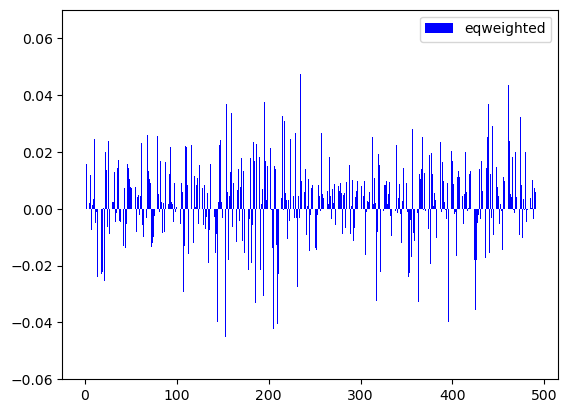

In [11]:
plt.bar(range(len(cv_summary)-2), cv_summary.iloc[:491, 0], align='edge', color='b', label='eqweighted')
plt.ylim(-0.06, 0.07)
plt.legend()

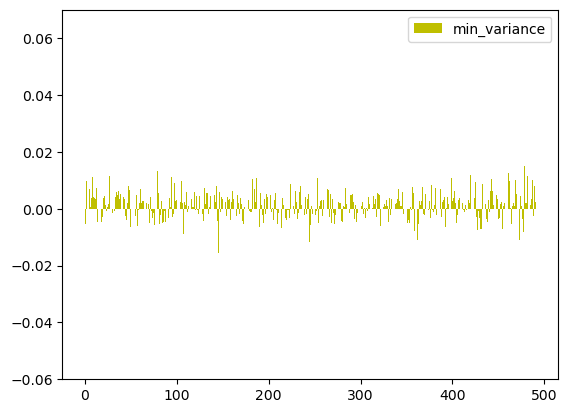

In [12]:
plt.bar(range(len(cv_summary)-2), cv_summary.iloc[:491, 1], align='edge', color='y', label='min_variance')
plt.ylim(-0.06, 0.07)
plt.legend()

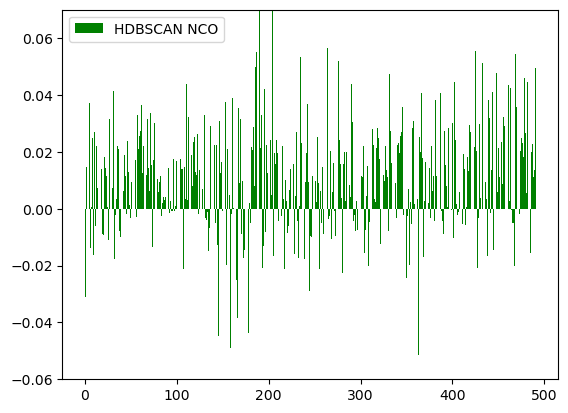

In [13]:
plt.bar(range(len(cv_summary)-2), cv_summary.iloc[:491, 2], align='edge', color='g', label='HDBSCAN NCO')
plt.ylim(-0.06, 0.07)
plt.legend()

In [14]:
cv_inds = needed_inds[:len(cv_summary[:-2])]
cv_summary.loc[returns.index, 'rf'] = np.array(RFs.loc[cv_inds])
eqw_cv_rps = cv_eqw_returns - np.array(cv_summary.iloc[:-2, 3])
mv_cv_rps = cv_minvar_returns - np.array(cv_summary.iloc[:-2, 3])
hnco_cv_rps = cv_hnco_returns - np.array(cv_summary.iloc[:-2, 3])

cv_summary.loc['Sharpe Ratio'] = np.array([eqw_cv_rps.mean(), mv_cv_rps.mean(), hnco_cv_rps.mean()])/cv_summary.iloc[-1, :3]

In [15]:
cv_summary

,eqweighted,minvariance,hnco,rf
2012-01-09,-0.0002169,-0.0054662,-0.0309185,0.0000000
2012-01-16,0.0156520,0.0096559,0.0146993,0.0000000
2012-01-23,0.0257426,-0.0025066,0.0258886,0.0000000
2012-01-30,-0.0011835,-0.0032906,0.0074460,0.0000000
2012-02-06,0.0315657,0.0028439,0.0383470,0.0000040
...,...,...,...,...
2021-05-24,0.0073129,0.0078695,0.0137393,0.0000000
2021-05-31,0.0058332,0.0024258,0.0496470,0.0000000
Mean Return,0.0023265,0.0013462,0.0108395,NaN
Volatility (std.),0.0142940,0.0045215,0.0188054,NaN
